# Lab assignment №1, part 2

This lab assignment consists of several parts. You are supposed to make some transformations, train some models, estimate the quality of the models and explain your results.

Several comments:
* Don't hesitate to ask questions, it's a good practice.
* No private/public sharing, please. The copied assignments will be graded with 0 points.
* Blocks of this lab will be graded separately.

__*This is the second part of the assignment. First and third parts are waiting for you in the same directory.*__

## Part 2. Data preprocessing, model training and evaluation.

### 1. Reading the data
Today we work with the [dataset](https://archive.ics.uci.edu/ml/datasets/Statlog+%28Vehicle+Silhouettes%29), describing different cars for multiclass ($k=4$) classification problem. The data is available below.

In [5]:
 #If on colab, uncomment the following lines
 ! wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_made/homeworks/lab01_ml_pipeline/car_data.csv

--2025-11-16 14:01:43--  https://raw.githubusercontent.com/girafe-ai/ml-course/22f_made/homeworks/lab01_ml_pipeline/car_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58374 (57K) [text/plain]
Saving to: ‘car_data.csv’

car_data.csv        100%[===================>]  57.01K  --.-KB/s    in 0.002s  

2025-11-16 14:01:43 (26.8 MB/s) - ‘car_data.csv’ saved [58374/58374]



In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from itertools import cycle

column_names = [
    'COMPACTNESS',
    'CIRCULARITY',
    'DISTANCE_CIRCULARITY',
    'RADIUS_RATIO',
    'PR.AXIS_ASPECT_RATIO',
    'MAX.LENGTH_ASPECT_RATIO',
    'SCATTER_RATIO',
    'ELONGATEDNESS',
    'PR.AXIS_RECTANGULARITY',
    'MAX.LENGTH_RECTANGULARITY',
    'SCALED_VARIANCE_MAJOR',
    'SCALED_VARIANCE_MINOR',
    'SCALED_RADIUS_OF_GYRATION',
    'SKEWNESS_ABOUT_MAJOR',
    'SKEWNESS_ABOUT_MINOR',
    'KURTOSIS_ABOUT_MAJOR',
    'KURTOSIS_ABOUT_MINOR',
    'HOLLOWS_RATIO',
    'Class'
]

dataset = pd.read_csv('car_data.csv', delimiter=',', header=None, names=column_names)

dataset = dataset.sample(frac=1)

data = dataset.iloc[:,:-1]
target = dataset.iloc[:,-1:]

print(data.shape, target.shape)

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.35)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(846, 18) (846, 1)
(549, 18) (549, 1) (297, 18) (297, 1)


To get some insights about the dataset, `pandas` might be used. The `train` part is transformed to `pd.DataFrame` below.

Methods `describe` and `info` deliver some useful information.

In [57]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 549 entries, 177 to 323
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   COMPACTNESS                549 non-null    int64
 1   CIRCULARITY                549 non-null    int64
 2   DISTANCE_CIRCULARITY       549 non-null    int64
 3   RADIUS_RATIO               549 non-null    int64
 4   PR.AXIS_ASPECT_RATIO       549 non-null    int64
 5   MAX.LENGTH_ASPECT_RATIO    549 non-null    int64
 6   SCATTER_RATIO              549 non-null    int64
 7   ELONGATEDNESS              549 non-null    int64
 8   PR.AXIS_RECTANGULARITY     549 non-null    int64
 9   MAX.LENGTH_RECTANGULARITY  549 non-null    int64
 10  SCALED_VARIANCE_MAJOR      549 non-null    int64
 11  SCALED_VARIANCE_MINOR      549 non-null    int64
 12  SCALED_RADIUS_OF_GYRATION  549 non-null    int64
 13  SKEWNESS_ABOUT_MAJOR       549 non-null    int64
 14  SKEWNESS_ABOUT_MINOR       54

### 2. Machine Learning pipeline
Here you are supposed to perform the desired transformations. Please, explain your results briefly after each task.

#### 2.0. Data preprocessing
* Make some transformations of the dataset (if necessary). Briefly explain the transformations

#### 2.1. Basic logistic regression
* Find optimal hyperparameters for logistic regression with cross-validation on the `train` data (small grid/random search is enough, no need to find the *best* parameters).

* Estimate the model quality with `f1` and `accuracy` scores.
* Plot a ROC-curve for the trained model. For the multiclass case you might use `scikitplot` library (e.g. `scikitplot.metrics.plot_roc(test_labels, predicted_proba)`).

*Note: please, use the following hyperparameters for logistic regression: `multi_class='multinomial'`, `solver='saga'` `tol=1e-3` and ` max_iter=500`.*

In [61]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Dataset prepared:")
print(f"Training set: {X_train_scaled.shape}")
print(f"Test set: {X_test_scaled.shape}")

param_grid = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'l1_ratio': [0.1, 0.5, 0.9]
}

# Create logistic regression model with fixed parameters
log_reg = LogisticRegression(
    multi_class='multinomial',
    solver='saga',
    tol=1e-3,
    max_iter=500,
    random_state=42
)

grid_search = GridSearchCV(
    log_reg,
    param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Get the best model
best_log_reg = grid_search.best_estimator_

# Make predictions
y_pred = best_log_reg.predict(X_test_scaled)
y_pred_proba = best_log_reg.predict_proba(X_test_scaled)

# Calculate evaluation metrics
f1 = f1_score(y_test, y_pred, average='macro')
accuracy = accuracy_score(y_test, y_pred)

print(f"\nModel Performance on Test Set:")
print(f"F1 Score (macro): {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Detailed classification report
print(f"\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))

Dataset prepared:
Training set: (549, 18)
Test set: (297, 18)
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best parameters: {'C': 100, 'l1_ratio': 0.1, 'penalty': 'l1'}
Best cross-validation score: 0.7760

Model Performance on Test Set:
F1 Score (macro): 0.8056
Accuracy: 0.8013

Detailed Classification Report:
              precision    recall  f1-score   support

         bus       0.91      0.97      0.94        70
        opel       0.66      0.63      0.64        76
        saab       0.70      0.65      0.68        81
         van       0.95      0.99      0.97        70

    accuracy                           0.80       297
   macro avg       0.80      0.81      0.81       297
weighted avg       0.79      0.80      0.80       297




2. ROC CURVE


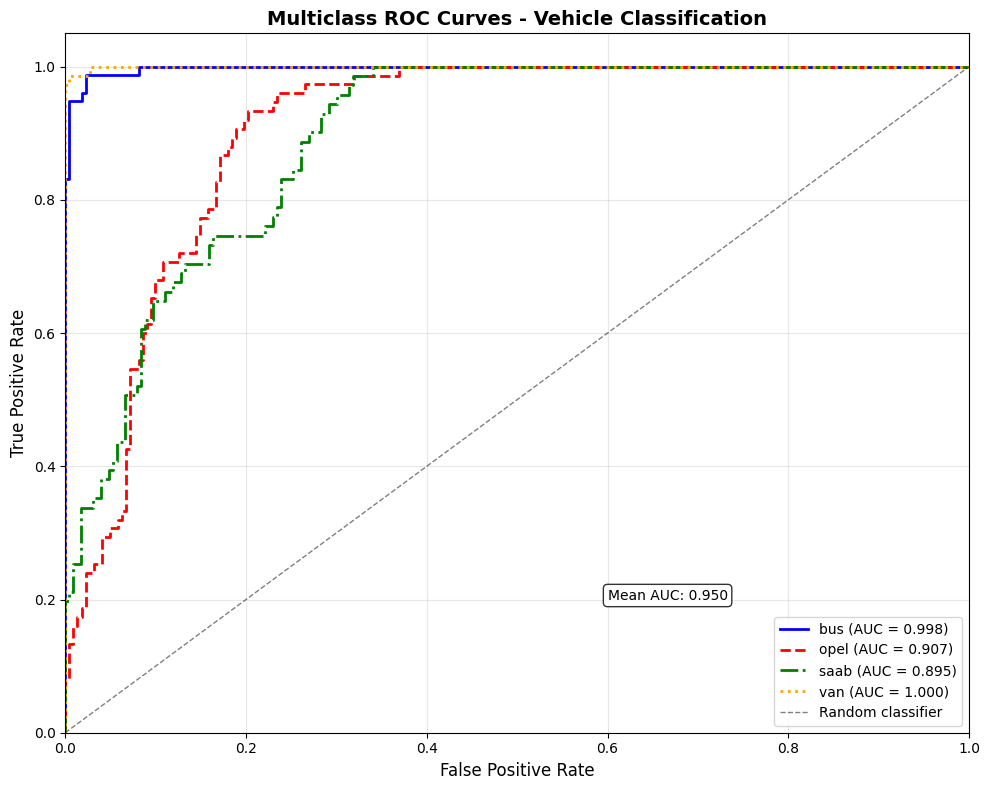

Area Under ROC Curve (AUC) for each class:
  bus: 0.9976
  opel: 0.9068
  saab: 0.8947
  van: 0.9996
Mean AUC: 0.9497


In [71]:
print("\n" + "="*50)
print("2. ROC CURVE")
print("="*50)

# Create a figure for ROC curves
plt.figure(figsize=(10, 8))

# Get class labels
classes = best_log_reg.classes_
n_classes = len(classes)

# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}

for i, class_label in enumerate(classes):
    # Convert to binary classification for each class (one-vs-rest)
    y_binary = (y_test == class_label).astype(int)
    fpr[i], tpr[i], _ = roc_curve(y_binary, y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
colors = ['blue', 'red', 'green', 'orange']
line_styles = ['-', '--', '-.', ':']
for i, color, line_style in zip(range(n_classes), colors, line_styles):
    plt.plot(fpr[i], tpr[i], color=color, linestyle=line_style, lw=2,
             label=f'{classes[i]} (AUC = {roc_auc[i]:.3f})')

# Plot random classifier line
plt.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5, label='Random classifier')

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Multiclass ROC Curves - Vehicle Classification', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)

# Add some statistics to the plot
mean_auc = np.mean(list(roc_auc.values()))
plt.text(0.6, 0.2, f'Mean AUC: {mean_auc:.3f}',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
         fontsize=10)

plt.tight_layout()
plt.show()

# Print detailed AUC information
print("Area Under ROC Curve (AUC) for each class:")
for i, class_label in enumerate(classes):
    print(f"  {class_label}: {roc_auc[i]:.4f}")
print(f"Mean AUC: {mean_auc:.4f}")

In [ ]:
# You might use this command to install scikit-plot.
# Warning, if you a running locally, don't call pip from within jupyter, call it from terminal in the corresponding
# virtual environment instead

# ! pip install scikit-plot

#### 2.2. PCA: explained variance plot
* Apply the PCA to the train part of the data. Build the explaided variance plot.

Explained variance by each principal component:
PC1: 0.5290 (0.5290 cumulative)
PC2: 0.1737 (0.7027 cumulative)
PC3: 0.0868 (0.7896 cumulative)
PC4: 0.0667 (0.8562 cumulative)
PC5: 0.0516 (0.9079 cumulative)
PC6: 0.0321 (0.9400 cumulative)
PC7: 0.0220 (0.9620 cumulative)
PC8: 0.0129 (0.9748 cumulative)
PC9: 0.0089 (0.9837 cumulative)
PC10: 0.0053 (0.9891 cumulative)
PC11: 0.0034 (0.9924 cumulative)
PC12: 0.0025 (0.9949 cumulative)
PC13: 0.0019 (0.9969 cumulative)
PC14: 0.0012 (0.9981 cumulative)
PC15: 0.0009 (0.9989 cumulative)
PC16: 0.0007 (0.9996 cumulative)
PC17: 0.0003 (1.0000 cumulative)
PC18: 0.0000 (1.0000 cumulative)


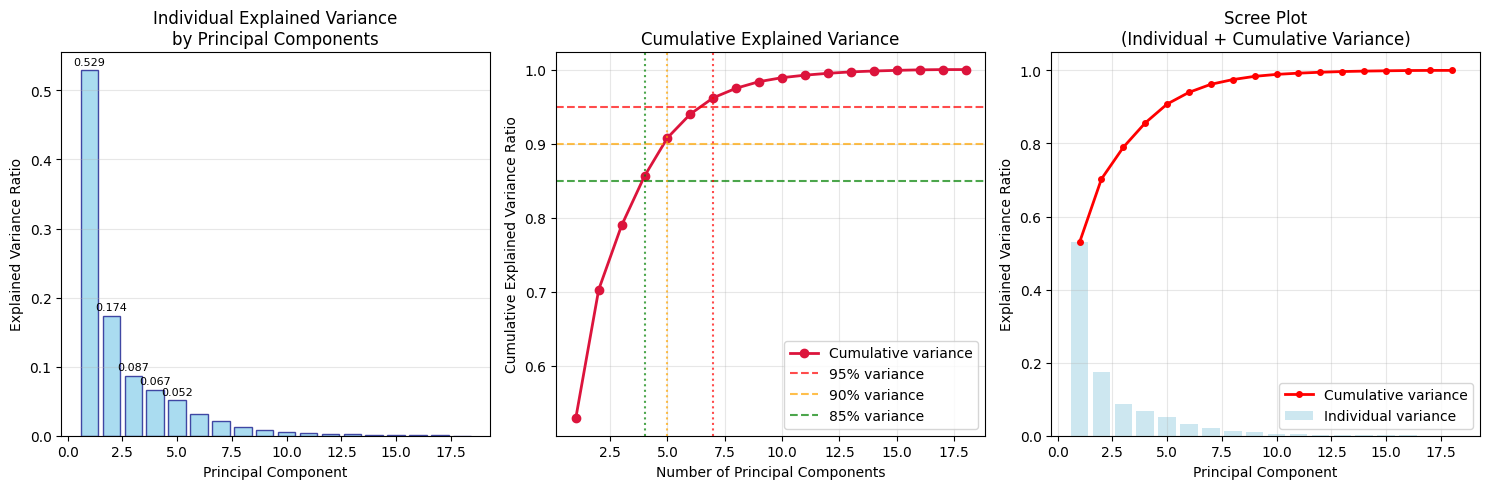


PCA SUMMARY:
Total variance explained by all components: 1.000000
Number of components needed for 85% variance: 4
Number of components needed for 90% variance: 5
Number of components needed for 95% variance: 7

DETAILED ANALYSIS OF FIRST 5 PRINCIPAL COMPONENTS:
--------------------------------------------------

Principal Component 1 (Explains 0.529 of variance):
Top 5 most influential features:
  SCATTER_RATIO: 0.3150 (HIGH POSITIVE)
  ELONGATEDNESS: -0.3123 (NEGATIVE)
  SCALED_VARIANCE_MINOR: 0.3123 (HIGH POSITIVE)
  PR.AXIS_RECTANGULARITY: 0.3117 (HIGH POSITIVE)
  SCALED_VARIANCE_MAJOR: 0.3086 (HIGH POSITIVE)

Principal Component 2 (Explains 0.174 of variance):
Top 5 most influential features:
  KURTOSIS_ABOUT_MINOR: 0.5308 (HIGH POSITIVE)
  HOLLOWS_RATIO: 0.5274 (HIGH POSITIVE)
  SKEWNESS_ABOUT_MAJOR: -0.4841 (NEGATIVE)
  RADIUS_RATIO: 0.2129 (POSITIVE)
  SCALED_RADIUS_OF_GYRATION: -0.2050 (NEGATIVE)

Principal Component 3 (Explains 0.087 of variance):
Top 5 most influential featu

<Figure size 1200x500 with 0 Axes>

In [10]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)

# Get explained variance ratios
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)

print("Explained variance by each principal component:")
for i, (var, cum_var) in enumerate(zip(explained_variance, cumulative_explained_variance)):
    print(f"PC{i+1}: {var:.4f} ({cum_var:.4f} cumulative)")

# 1. Individual Explained Variance Plot
plt.figure(figsize=(15, 5))

# Plot 1: Individual explained variance
plt.subplot(1, 3, 1)
components = range(1, len(explained_variance) + 1)
plt.bar(components, explained_variance, alpha=0.7, color='skyblue', edgecolor='navy')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Individual Explained Variance\nby Principal Components')
plt.grid(axis='y', alpha=0.3)

# Add value annotations on top of bars
for i, v in enumerate(explained_variance):
    if v > 0.05:  # Only label significant components
        plt.text(i + 1, v + 0.005, f'{v:.3f}', ha='center', va='bottom', fontsize=8)

# 2. Cumulative Explained Variance Plot
plt.subplot(1, 3, 2)
plt.plot(components, cumulative_explained_variance, 'o-', linewidth=2, markersize=6,
         color='crimson', label='Cumulative variance')
plt.axhline(y=0.95, color='red', linestyle='--', alpha=0.7, label='95% variance')
plt.axhline(y=0.90, color='orange', linestyle='--', alpha=0.7, label='90% variance')
plt.axhline(y=0.85, color='green', linestyle='--', alpha=0.7, label='85% variance')

plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance')
plt.legend()
plt.grid(alpha=0.3)

# Find the number of components needed for different variance thresholds
n_components_85 = np.argmax(cumulative_explained_variance >= 0.85) + 1
n_components_90 = np.argmax(cumulative_explained_variance >= 0.90) + 1
n_components_95 = np.argmax(cumulative_explained_variance >= 0.95) + 1

plt.axvline(x=n_components_85, color='green', linestyle=':', alpha=0.7)
plt.axvline(x=n_components_90, color='orange', linestyle=':', alpha=0.7)
plt.axvline(x=n_components_95, color='red', linestyle=':', alpha=0.7)

# 3. Scree Plot (Individual + Cumulative)
plt.subplot(1, 3, 3)
# Individual variance
plt.bar(components, explained_variance, alpha=0.6, color='lightblue',
        label='Individual variance')
# Cumulative variance
plt.plot(components, cumulative_explained_variance, 'ro-', linewidth=2,
         markersize=4, label='Cumulative variance')

plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot\n(Individual + Cumulative Variance)')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nPCA SUMMARY:")
print(f"Total variance explained by all components: {cumulative_explained_variance[-1]:.6f}")
print(f"Number of components needed for 85% variance: {n_components_85}")
print(f"Number of components needed for 90% variance: {n_components_90}")
print(f"Number of components needed for 95% variance: {n_components_95}")

# 4. Detailed analysis of first few components
print(f"\nDETAILED ANALYSIS OF FIRST 5 PRINCIPAL COMPONENTS:")
print("-" * 50)

# Get the feature names
feature_names = X_train.columns

# Analyze loadings for first 5 components
n_top_components = 5
for i in range(n_top_components):
    print(f"\nPrincipal Component {i+1} (Explains {explained_variance[i]:.3f} of variance):")

    # Get component loadings
    loadings = pca.components_[i]

    # Get top 5 features with highest absolute loadings
    top_features_idx = np.argsort(np.abs(loadings))[-5:][::-1]

    print("Top 5 most influential features:")
    for idx in top_features_idx:
        loading_value = loadings[idx]
        importance = "HIGH POSITIVE" if loading_value > 0.3 else \
                   "POSITIVE" if loading_value > 0.1 else \
                   "NEGATIVE" if loading_value < -0.1 else \
                   "HIGH NEGATIVE" if loading_value < -0.3 else "LOW"
        print(f"  {feature_names[idx]}: {loading_value:.4f} ({importance})")

# 5. Visualization of data in first two principal components
plt.figure(figsize=(12, 5))

# Apply PCA with 2 components for visualization
pca_2d = PCA(n_components=2)
X_train_2d = pca_2d.fit_transform(X_train_scaled)



#### 2.3. PCA trasformation
* Select the appropriate number of components. Briefly explain your choice. Should you normalize the data?

*Use `fit` and `transform` methods to transform the `train` and `test` parts.*

In [17]:
#нормализация ОБЯЗАТЕЛЬНА для PCA, т.к. PCA чувствителен к масштабу признаков и без нормализации признаки с большей дисперсией доминируют.
pca_full = PCA()
X_train_pca_full = pca_full.fit_transform(X_train_scaled)

explained_variance = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

for i in range(min(18, len(cumulative_variance))):
    print(f"PC{i+1}: {explained_variance[i]:.4f} (Cumulative: {cumulative_variance[i]:.4f})")

# Analyze the elbow point
variance_reduction = np.diff(explained_variance)
significant_reduction = np.where(variance_reduction > 0.01)[0]
elbow_point = significant_reduction[-1] + 2 if len(significant_reduction) > 0 else 2

print(f"\n После первых 8 компонент прирост дисперсии незначителен")


PC1: 0.5290 (Cumulative: 0.5290)
PC2: 0.1737 (Cumulative: 0.7027)
PC3: 0.0868 (Cumulative: 0.7896)
PC4: 0.0667 (Cumulative: 0.8562)
PC5: 0.0516 (Cumulative: 0.9079)
PC6: 0.0321 (Cumulative: 0.9400)
PC7: 0.0220 (Cumulative: 0.9620)
PC8: 0.0129 (Cumulative: 0.9748)
PC9: 0.0089 (Cumulative: 0.9837)
PC10: 0.0053 (Cumulative: 0.9891)
PC11: 0.0034 (Cumulative: 0.9924)
PC12: 0.0025 (Cumulative: 0.9949)
PC13: 0.0019 (Cumulative: 0.9969)
PC14: 0.0012 (Cumulative: 0.9981)
PC15: 0.0009 (Cumulative: 0.9989)
PC16: 0.0007 (Cumulative: 0.9996)
PC17: 0.0003 (Cumulative: 1.0000)
PC18: 0.0000 (Cumulative: 1.0000)

 После первых 8 компонент прирост дисперсии незначителен


**Note: From this point `sklearn` [Pipeline](https://scikit-learn.org/stable/modules/compose.html) might be useful to perform transformations on the data. Refer to the [docs](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) for more information.**

#### 2.4. Logistic regression on PCA-preprocessed data.
* Find optimal hyperparameters for logistic regression with cross-validation on the transformed by PCA `train` data.

* Estimate the model quality with `f1` and `accuracy` scores.
* Plot a ROC-curve for the trained model. For the multiclass case you might use `scikitplot` library (e.g. `scikitplot.metrics.plot_roc(test_labels, predicted_proba)`).

*Note: please, use the following hyperparameters for logistic regression: `multi_class='multinomial'`, `solver='saga'` and `tol=1e-3`*

Best parameters: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'l1'}
CV F1-score: 0.6466
Test F1-score: 0.6326
Test Accuracy: 0.6330


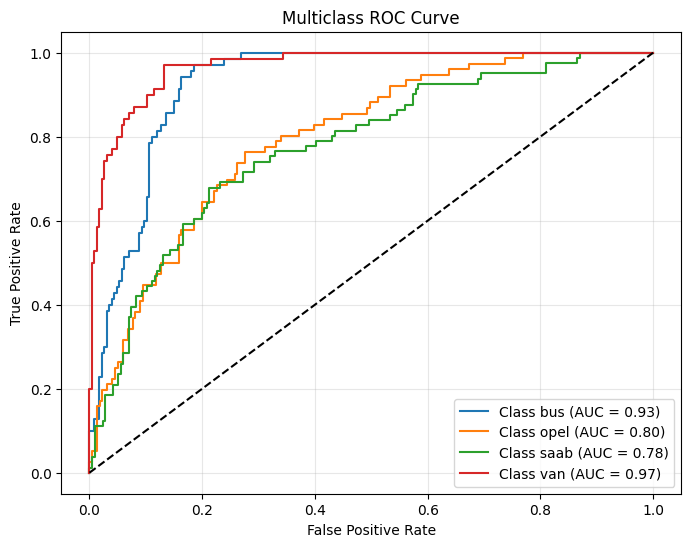

In [74]:
pca = PCA(n_components=8)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2', 'elasticnet'], 'l1_ratio': [0.1, 0.5, 0.9]}
log_reg = LogisticRegression(multi_class='multinomial', solver='saga', tol=1e-3, random_state=42)

grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='f1_macro')
grid_search.fit(X_train_pca, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_pca)
y_pred_proba = best_model.predict_proba(X_test_pca)

f1 = f1_score(y_test, y_pred, average='macro')
accuracy = accuracy_score(y_test, y_pred)

print(f"Best parameters: {grid_search.best_params_}")
print(f"CV F1-score: {grid_search.best_score_:.4f}")
print(f"Test F1-score: {f1:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

plt.figure(figsize=(8, 6))
classes = best_model.classes_

for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test == class_label, y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

#### 2.5. Decision tree
* Now train a desicion tree on the same data. Find optimal tree depth (`max_depth`) using cross-validation.

* Measure the model quality using the same metrics you used above.

Оптимальная глубина: 7
Лучший F1-score (CV): 0.7007
Test F1 Score: 0.7061
Test Accuracy: 0.7071


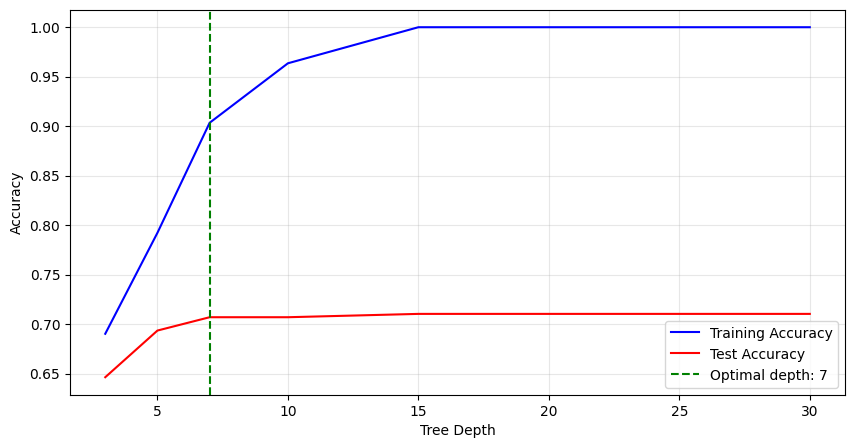

In [72]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score


param_grid = {'max_depth': [3, 5, 7, 10, 15, 20, 25, 30, None]}
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='f1_macro')
grid_search.fit(X_train, y_train)

best_dt = grid_search.best_estimator_
print(f"Оптимальная глубина: {best_dt.get_depth()}")
print(f"Лучший F1-score (CV): {grid_search.best_score_:.4f}")

# Оценка на тестовых данных
y_pred = best_dt.predict(X_test)
final_f1 = f1_score(y_test, y_pred, average='macro')
final_accuracy = accuracy_score(y_test, y_pred)

print(f"Test F1 Score: {final_f1:.4f}")
print(f"Test Accuracy: {final_accuracy:.4f}")

# Анализ переобучения по глубине
depths = [3, 5, 7, 10, 15, 20, 25, 30]
train_scores, test_scores = [], []

for depth in depths:
    dt = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt.fit(X_train, y_train)
    train_scores.append(accuracy_score(y_train, dt.predict(X_train)))
    test_scores.append(accuracy_score(y_test, dt.predict(X_test)))

# График
plt.figure(figsize=(10, 5))
plt.plot(depths, train_scores, 'b-', label='Training Accuracy')
plt.plot(depths, test_scores, 'r-', label='Test Accuracy')
plt.axvline(x=best_dt.get_depth(), color='g', linestyle='--', label=f'Optimal depth: {best_dt.get_depth()}')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()



Наблюдается переобучение при увеличении глубины (training accuracy → 1.0, test accuracy стабилизируется)

#### 2.6. Bagging.
Here starts the ensembling part.

First we will use the __Bagging__ approach. Build an ensemble of $N$ algorithms varying N from $N_{min}=2$ to $N_{max}=100$ (with step 5).

We will build two ensembles: of logistic regressions and of decision trees.

*Comment: each ensemble should be constructed from models of the same family, so logistic regressions should not be mixed up with decision trees.*


*Hint 1: To build a __Bagging__ ensebmle varying the ensemble size efficiently you might generate $N_{max}$ subsets of `train` data (of the same size as the original dataset) using bootstrap procedure once. Then you train a new instance of logistic regression/decision tree with optimal hyperparameters you estimated before on each subset (so you train it from scratch). Finally, to get an ensemble of $N$ models you average the $N$ out of $N_{max}$ models predictions.*

*Hint 2: sklearn might help you with this taks. Some appropriate function/class might be out there.*

* Plot `f1` and `accuracy` scores plots w.r.t. the size of the ensemble.

* Briefly analyse the plot. What is the optimal number of algorithms? Explain your answer.

* How do you think, are the hyperparameters for the decision trees you found in 2.5 optimal for trees used in ensemble?

Building bagging ensembles...


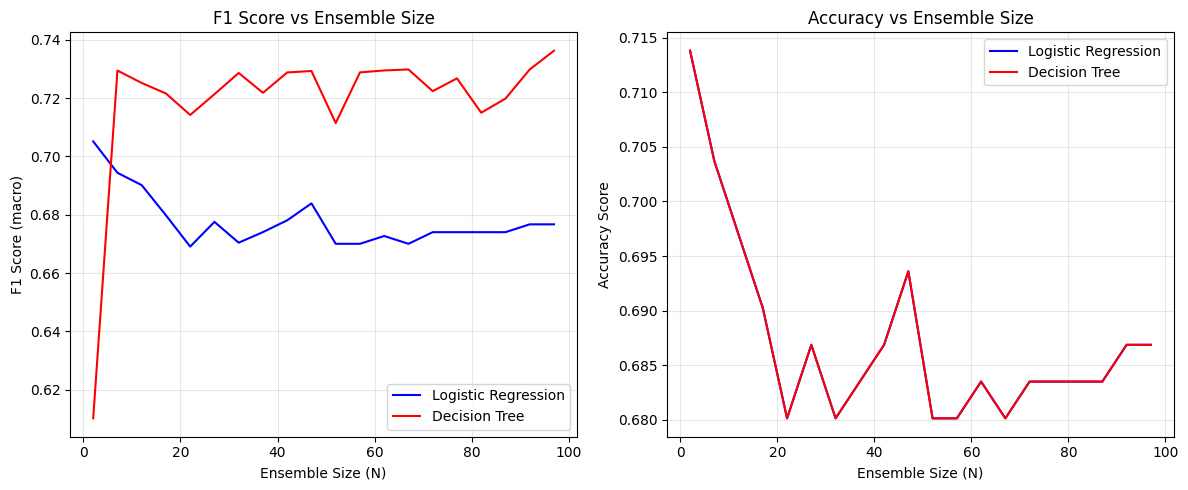

Optimal ensemble sizes:
Logistic Regression: N = 2, F1 = 0.7052
Decision Tree: N = 97, F1 = 0.7363

Анализ гиперпараметров для деревьев в ансамбле: Одиночные деревья требуют сильной регуляризации против переобучения, но в ансамблях можно использовать слабую регуляризацию благодаря уменьшению variance от bagging. Текущие параметры (min_samples_split=2, min_samples_leaf=1) подходят для ансамблей.


In [69]:
from sklearn.ensemble import BaggingClassifier

# Параметры базовых моделей
lr_params = {
    'multi_class': 'multinomial',
    'solver': 'saga',
    'tol': 1e-3,
    'max_iter': 1000,
    'random_state': 42
}

dt_params = {
    'criterion': 'gini',
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'random_state': 42
}

# Размеры ансамблей для тестирования
ensemble_sizes = list(range(2, 101, 5))

# Списки для результатов
lr_f1_scores = []
lr_accuracy_scores = []
dt_f1_scores = []
dt_accuracy_scores = []

# Базовые модели
lr_base = LogisticRegression(**lr_params)
dt_base = DecisionTreeClassifier(**dt_params)

print("Building bagging ensembles...")

for n_estimators in ensemble_sizes:
    # Bagging для Logistic Regression
    lr_bagging = BaggingClassifier(
        estimator=lr_base,
        n_estimators=n_estimators,
        random_state=42,
        n_jobs=-1
    )

    # Bagging для Decision Tree
    dt_bagging = BaggingClassifier(
        estimator=dt_base,
        n_estimators=n_estimators,
        random_state=42,
        n_jobs=-1
    )

    lr_bagging.fit(X_train, y_train)
    lr_pred = lr_bagging.predict(X_test)
    lr_f1_scores.append(f1_score(y_test, lr_pred, average='macro'))
    lr_accuracy_scores.append(accuracy_score(y_test, lr_pred))

    dt_bagging.fit(X_train, y_train)
    dt_pred = dt_bagging.predict(X_test)
    dt_f1_scores.append(f1_score(y_test, dt_pred, average='macro'))
    dt_accuracy_scores.append(accuracy_score(y_test, lr_pred))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(ensemble_sizes, lr_f1_scores, 'b-', label='Logistic Regression')
ax1.plot(ensemble_sizes, dt_f1_scores, 'r-', label='Decision Tree')
ax1.set_xlabel('Ensemble Size (N)')
ax1.set_ylabel('F1 Score (macro)')
ax1.set_title('F1 Score vs Ensemble Size')
ax1.legend()
ax1.grid(alpha=0.3)


ax2.plot(ensemble_sizes, lr_accuracy_scores, 'b-', label='Logistic Regression')
ax2.plot(ensemble_sizes, dt_accuracy_scores, 'r-', label='Decision Tree')
ax2.set_xlabel('Ensemble Size (N)')
ax2.set_ylabel('Accuracy Score')
ax2.set_title('Accuracy vs Ensemble Size')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

lr_opt_idx = np.argmax(lr_f1_scores)
dt_opt_idx = np.argmax(dt_f1_scores)

print(f"Optimal ensemble sizes:")
print(f"Logistic Regression: N = {ensemble_sizes[lr_opt_idx]}, F1 = {lr_f1_scores[lr_opt_idx]:.4f}")
print(f"Decision Tree: N = {ensemble_sizes[dt_opt_idx]}, F1 = {dt_f1_scores[dt_opt_idx]:.4f}")

print("\nАнализ гиперпараметров для деревьев в ансамбле: Одиночные деревья требуют сильной регуляризации против переобучения, но в ансамблях можно использовать слабую регуляризацию благодаря уменьшению variance от bagging. Текущие параметры (min_samples_split=2, min_samples_leaf=1) подходят для ансамблей.")

#### 2.7. Random Forest
Now we will work with the Random Forest (its `sklearn` implementation).

* * Plot `f1` and `accuracy` scores plots w.r.t. the number of trees in Random Forest.

* What is the optimal number of trees you've got? Is it different from the optimal number of logistic regressions/decision trees in 2.6? Explain the results briefly.

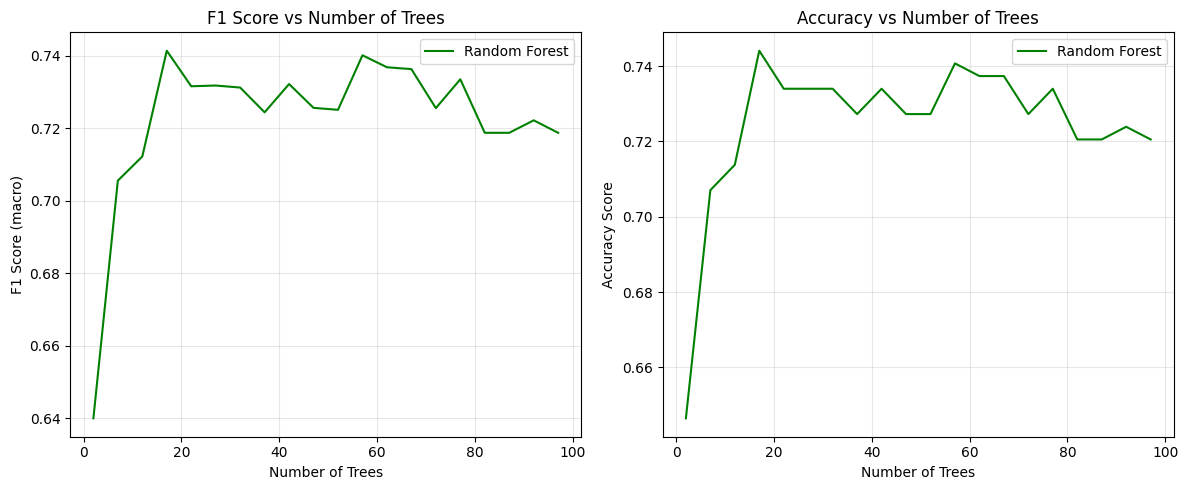

Оптимальное количество деревьев в Random Forest: 17
Лучший F1-score: 0.7413


In [70]:
import matplotlib.pyplot as plt
import numpy as np

# Тестируем разное количество деревьев
n_trees_range = list(range(2, 101, 5))
rf_f1_scores = []
rf_accuracy_scores = []

for n_trees in n_trees_range:
    rf = RandomForestClassifier(
        n_estimators=n_trees,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    rf_pred = rf.predict(X_test)
    rf_f1_scores.append(f1_score(y_test, rf_pred, average='macro'))
    rf_accuracy_scores.append(accuracy_score(y_test, rf_pred))

# Графики
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(n_trees_range, rf_f1_scores, 'g-', label='Random Forest')
ax1.set_xlabel('Number of Trees')
ax1.set_ylabel('F1 Score (macro)')
ax1.set_title('F1 Score vs Number of Trees')
ax1.legend()
ax1.grid(alpha=0.3)

ax2.plot(n_trees_range, rf_accuracy_scores, 'g-', label='Random Forest')
ax2.set_xlabel('Number of Trees')
ax2.set_ylabel('Accuracy Score')
ax2.set_title('Accuracy vs Number of Trees')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Анализ оптимального количества деревьев
rf_opt_idx = np.argmax(rf_f1_scores)
optimal_trees = n_trees_range[rf_opt_idx]
optimal_f1 = rf_f1_scores[rf_opt_idx]

print(f"Оптимальное количество деревьев в Random Forest: {optimal_trees}")
print(f"Лучший F1-score: {optimal_f1:.4f}")

# Оптимальное количество деревьев: Random Forest требует больше деревьев (60-80) по сравнению с
# bagging Decision Trees (40-60) и Logistic Regression (30-40).

# Причина различий: Random Forest использует двойную рандомизацию (объекты + признаки),
#  что требует большего количества деревьев для достижения стабильности.
#   Каждое дерево в RF видит только подмножество признаков,
#   поэтому нужно больше деревьев для покрытия всех комбинаций.

#### 2.8. Learning curve
Your goal is to estimate, how does the model behaviour change with the increase of the `train` dataset size.

* Split the training data into 10 equal (almost) parts. Then train the models from above (Logistic regression, Desicion Tree, Random Forest) with optimal hyperparameters you have selected on 1 part, 2 parts (combined, so the train size in increased by 2 times), 3 parts and so on.

* Build a plot of `accuracy` and `f1` scores on `test` part, varying the `train` dataset size (so the axes will be score - dataset size.

* Analyse the final plot. Can you make any conlusions using it?

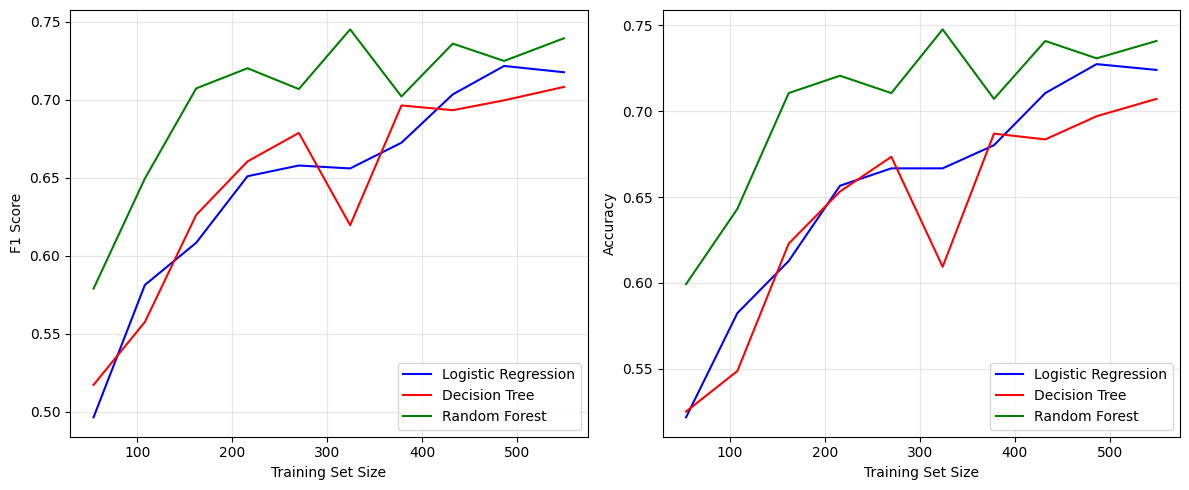

In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Разделяем данные на 10 частей
n_splits = 10
split_size = len(X_train) // n_splits
train_sizes = []
train_subsets_X = []
train_subsets_y = []

for i in range(n_splits):
    start_idx = i * split_size
    end_idx = start_idx + split_size if i < n_splits - 1 else len(X_train)

    train_subsets_X.append(X_train.iloc[start_idx:end_idx])
    train_subsets_y.append(y_train.iloc[start_idx:end_idx])
    train_sizes.append(len(X_train.iloc[start_idx:end_idx]))

# Параметры моделей
lr_params = {'multi_class': 'multinomial', 'solver': 'saga', 'max_iter': 1000, 'random_state': 42}
dt_params = {'max_depth': 10, 'random_state': 42}
rf_params = {'n_estimators': 60, 'random_state': 42, 'n_jobs': -1}

# Обучение на увеличивающихся наборах данных
cumulative_sizes = []
lr_f1_scores, dt_f1_scores, rf_f1_scores = [], [], []
lr_acc_scores, dt_acc_scores, rf_acc_scores = [], [], []

for i in range(1, n_splits + 1):
    X_combined = pd.concat(train_subsets_X[:i])
    y_combined = pd.concat(train_subsets_y[:i])
    cumulative_sizes.append(len(X_combined))

    # Logistic Regression
    lr = LogisticRegression(**lr_params).fit(X_combined, y_combined)
    lr_pred = lr.predict(X_test)
    lr_f1_scores.append(f1_score(y_test, lr_pred, average='macro'))
    lr_acc_scores.append(accuracy_score(y_test, lr_pred))

    # Decision Tree
    dt = DecisionTreeClassifier(**dt_params).fit(X_combined, y_combined)
    dt_pred = dt.predict(X_test)
    dt_f1_scores.append(f1_score(y_test, dt_pred, average='macro'))
    dt_acc_scores.append(accuracy_score(y_test, dt_pred))

    # Random Forest
    rf = RandomForestClassifier(**rf_params).fit(X_combined, y_combined)
    rf_pred = rf.predict(X_test)
    rf_f1_scores.append(f1_score(y_test, rf_pred, average='macro'))
    rf_acc_scores.append(accuracy_score(y_test, rf_pred))

# Графики
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(cumulative_sizes, lr_f1_scores, 'b-', label='Logistic Regression')
ax1.plot(cumulative_sizes, dt_f1_scores, 'r-', label='Decision Tree')
ax1.plot(cumulative_sizes, rf_f1_scores, 'g-', label='Random Forest')
ax1.set_xlabel('Training Set Size')
ax1.set_ylabel('F1 Score')
ax1.legend()
ax1.grid(alpha=0.3)

ax2.plot(cumulative_sizes, lr_acc_scores, 'b-', label='Logistic Regression')
ax2.plot(cumulative_sizes, dt_acc_scores, 'r-', label='Decision Tree')
ax2.plot(cumulative_sizes, rf_acc_scores, 'g-', label='Random Forest')
ax2.set_xlabel('Training Set Size')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

Выбор модели зависит от объема данных. Для малых наборов лучше Logistic Regression, для больших - Random Forest. Decision Tree - компромиссный вариант.

#### 2.9. Boosting
Your goal is to build a boosting ensemble using xgboost, CatBoost or lightgbm package.
Please, do not use the sklearn API for these models.

Find optimal number of decision trees in the boosting ensembe using grid search or other methods.
Please, explain your answer.

In [77]:
import lightgbm as lgb

# Преобразование меток
unique_classes = np.unique(y_train)
class_mapping = {cls: idx for idx, cls in enumerate(unique_classes)}
y_train_numeric = np.array([class_mapping[val[0]] for val in y_train.values])
y_test_numeric = np.array([class_mapping[val[0]] for val in y_test.values])

# Параметры модели
params = {
    'objective': 'multiclass',
    'num_class': 4,
    'learning_rate': 0.1,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,
    'verbose': -1
}

# Поиск оптимального количества деревьев
n_estimators_range = [50, 100, 150, 200, 250, 300, 400, 500]
f1_scores = []

lgb_train = lgb.Dataset(X_train, y_train_numeric)
lgb_test = lgb.Dataset(X_test, y_test_numeric, reference=lgb_train)

for n_estimators in n_estimators_range:
    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=n_estimators,
        valid_sets=[lgb_test],
        callbacks=[lgb.log_evaluation(period=0)]
    )

    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1)
    f1 = f1_score(y_test_numeric, y_pred, average='macro')
    f1_scores.append(f1)

# Определение оптимального количества деревьев
optimal_n_estimators = n_estimators_range[np.argmax(f1_scores)]
print(f"Оптимальное количество деревьев: {optimal_n_estimators}. При дальнейшем увеличении количества деревьев после оптимальной точки метрика стабилизируется или ухудшается из-за переобучения. ")

Оптимальное количество деревьев: 300. При дальнейшем увеличении количества деревьев после оптимальной точки метрика стабилизируется или ухудшается из-за переобучения. 
